In [21]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\Ferna\AppData\Local\Temp\ipykernel_9324\1125218647.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD )
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Average_Price,Money_Flow,Pos_Flow,Neg_Flow,MFI,MFI_Strategy,BB_SMA,STDV,Upper_Band,Lower_Band,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
19,52.599998,53.779999,52.299999,53.220001,139208,52.893332,7.363175e+06,7.363175e+06,0.000000e+00,71.344818,-1.0,50.048120,4.151802,54.199922,45.896318,0.0,-1.0,0,0.502857,0.000000
20,50.119999,52.641998,49.032001,52.641998,262140,50.598000,1.326376e+07,0.000000e+00,1.326376e+07,64.472534,-1.0,50.804120,2.172075,52.976195,48.632045,0.0,-1.0,0,0.432000,0.000000
21,50.645000,51.470001,49.049999,50.049999,150561,50.388334,7.586518e+06,0.000000e+00,7.586518e+06,54.862770,-1.0,50.878870,2.137605,53.016475,48.741265,0.0,-1.0,0,0.447000,0.000000
22,50.599998,51.459999,50.230000,50.450802,57633,50.763332,2.925643e+06,2.925643e+06,0.000000e+00,44.969346,0.0,51.008870,2.029644,53.038514,48.979226,0.0,0.0,0,0.445714,0.000000
23,49.900002,51.000000,49.299999,50.520000,73831,50.066667,3.696472e+06,0.000000e+00,3.696472e+06,48.138943,0.0,51.110620,1.911300,53.021920,49.199320,0.0,0.0,0,0.425714,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,74.279999,74.589996,72.959999,73.690002,85148,73.943331,6.296127e+06,0.000000e+00,6.296127e+06,45.217195,0.0,74.641319,1.281033,75.922352,73.360287,0.0,0.0,0,1.122286,-0.661114
3408,74.110001,74.540001,73.940002,74.110001,28777,74.196668,2.135158e+06,2.135158e+06,0.000000e+00,43.137917,0.0,74.729319,1.171080,75.900399,73.558240,0.0,0.0,0,1.117429,-0.661114
3409,73.790001,74.410004,73.570297,74.110001,52939,73.923434,3.913433e+06,0.000000e+00,3.913433e+06,44.100708,0.0,74.805320,1.045684,75.851004,73.759636,0.0,0.0,0,1.108286,-0.661114
3410,74.129997,74.230003,73.779999,73.839996,45549,74.046666,3.372752e+06,3.372752e+06,0.000000e+00,49.072648,0.0,74.928819,0.762049,75.690868,74.166770,0.0,0.0,0,1.118000,-0.661114


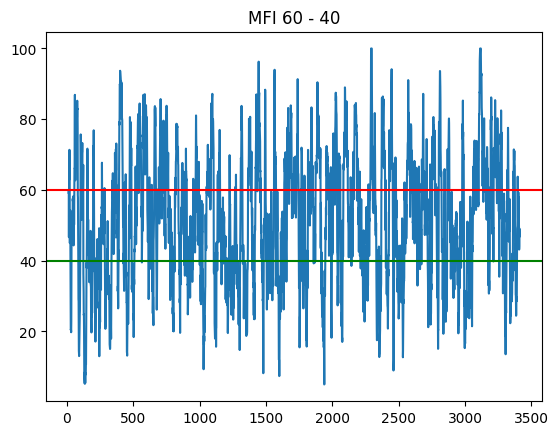

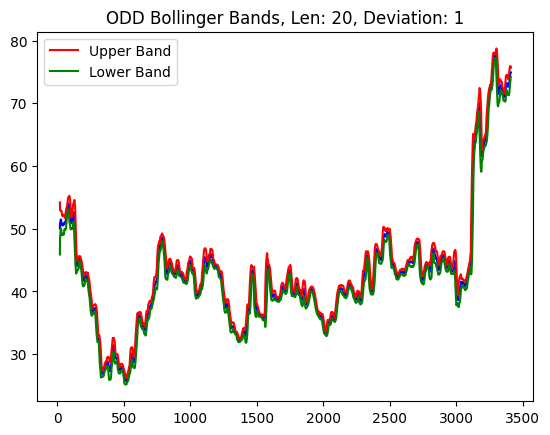

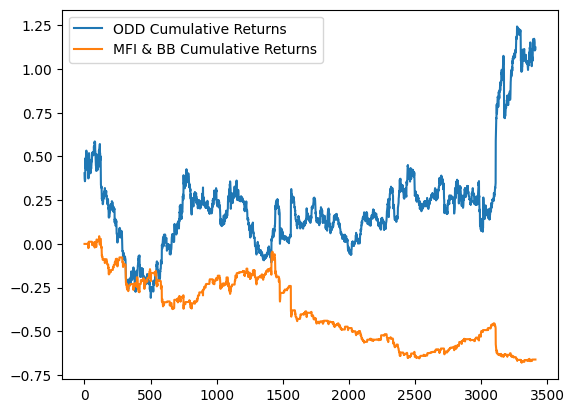

In [22]:
# General parameters
TICKER = 'ODD'
INTERVAL = '1h'
LEVERAGE = 1

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

# BB parameters
BB_LEN = 20
DEV = 1

# MFI parameters
MFI_LENGHT = 14
MFI_OVERBOUGHT = 60
MFI_OVERSOLD = 40

# subsection of data we are interested
LOOKBACK = 10000

def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # get data at interval
    df = yf.download(ticker, interval = interval, period = PERIOD ) 
    df.columns = df.columns.get_level_values(0)

    df = df.reset_index(drop = True) # Changes dates to numbers so we don't have weird weekend gaps when plotting

    return df.iloc[-lookback:,:] #Take a piece of the last "LOOKBACK" rows

def add_MFI(df, lenght = MFI_LENGHT):

    #Typical/Average Price
    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']

    #initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Money_Flow'], 0)

    mfr = df['Pos_Flow'].rolling(lenght).sum() / df['Neg_Flow'].rolling(lenght).sum()
    df['MFI'] = 100 - (100 / (1 + mfr))

    return df

def add_MFI_strategy(df, overbought = MFI_OVERBOUGHT, oversold = MFI_OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, np.where(df['MFI'] < oversold, 1, 0))
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)

    plt.plot(df['MFI'])
    plt.axhline(overbought, color = 'red')
    plt.axhline(oversold, color = 'green')
    plt.title(f'MFI {MFI_OVERBOUGHT} - {MFI_OVERSOLD}')

    return df

def add_bollinger_bands(df, ticker = TICKER, dev = DEV, bb_len = BB_LEN):

    # can use ema
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['STDV'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (dev * df['STDV'])
    df['Lower_Band'] = df['BB_SMA'] - (dev * df['STDV'])

    plt.figure()
    plt.plot(df['BB_SMA'], color = 'blue')
    plt.plot(df['Upper_Band'], color = 'red', label='Upper Band')
    plt.plot(df['Lower_Band'], color = 'green', label='Lower Band')
    plt.title(f'{ticker} Bollinger Bands, Len: {bb_len}, Deviation: {dev}')
    plt.legend()

    return df

def add_bb_strategy(df):

    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(df['Close'] > df['Upper_Band'], -1, np.where(df['Close'] < df['Lower_Band'], 1, 0))
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df, leverage = LEVERAGE):
    df['Full_Strategy'] = df['BB_Strategy'] + df['MFI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, leverage, np.where(df['Full_Strategy'] == -2, -leverage, 0))

    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])

    plt.legend([f'{TICKER} Cumulative Returns', f'MFI & BB Cumulative Returns'])

    return df

def main():
    df = get_data()
    df = add_MFI(df)
    df = add_MFI_strategy(df)
    df = add_bollinger_bands(df)
    df = add_bb_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df.dropna()

df = main()
df